In [15]:
import os
import warnings

import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

from train import create_net

warnings.filterwarnings("ignore")
np.random.seed(63910)
torch.manual_seed(53152)
torch.cuda.manual_seed_all(7987)
torch.backends.cudnn.deterministic = True

os.environ['CUDA_VISIBLE_DEVICES'] = '2'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
n_channels, n_classes, batch_size = 1, 4, 128

transform = T.Compose([
    T.Resize(81), # 缩放图片(Image)，保持长宽比不变，最短边为img_size像素
    T.CenterCrop(81), # 从图片中间切出img_size*img_size的图片
    T.ToTensor(), # 将图片(Image)转成Tensor，归一化至[0, 1]
])

train = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/train/', transform=transform, loader=lambda path: Image.open(path))
val = ImageFolder('/nfs3-p1/zsxm/dataset/aorta_classify_ct_-100_500/val/', transform=transform, loader=lambda path: Image.open(path))
train_loader = DataLoader(train, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=False)

In [3]:
net = create_net(device, 'resnet', 34, n_channels, n_classes, '/nfs3-p2/zsxm/temp_path/single81.pth', entire=True)
net.eval()
print('')

[INFO]: **********************************************************************
Network: ResNet_34
	1 input channels
	4 output channels (classes)
	3D model: False

[INFO]: Model loaded from /nfs3-p2/zsxm/temp_path/single81.pth



In [4]:
class HookModule:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        return grads[0]
    
    def remove(self):
        self.handle.remove()
        
hook = HookModule(net, net.encoder.layer4[2].conv1)

In [5]:
def get_grads(dataset, dataloader, end=500, start=0):
    idx = 0
    score_list = [[] for _ in range(n_classes)]
    for imgs, true_categories in tqdm(dataloader, total=len(dataloader), desc='Dataset', unit='batch', leave=False):
        imgs = imgs.to(device=device, dtype=torch.float32)
        true_categories = true_categories.to(device=device, dtype=torch.long)

        with torch.no_grad():
            categories_pred = torch.softmax(net(imgs), dim=1)
            labels_pred = categories_pred.argmax(dim=1)
            for i in range(len(true_categories)):
                if labels_pred[i] == true_categories[i]:
                    score_list[true_categories[i].item()].append((categories_pred[i, labels_pred[i]].item(), idx))
                idx += 1
                
    grad_list = []
    mask_list = []
    for i in range(n_classes):
        print(len(score_list[i]))
        score_list[i].sort(key=lambda x: x[0], reverse=True)
        print(score_list[i][end-1])
        idx_list = [score[1] for score in score_list[i][start: end]]
        tensor_list = []
        for idx in idx_list:
            tensor_list.append(dataset[idx][0])
        batch = torch.stack(tensor_list, dim=0)
        pred = net(batch.to(device))
        nll_loss = F.nll_loss(pred, (torch.ones(batch.size(0))*i).to(device, dtype=torch.long))
        grads = hook.grads(-nll_loss, True, False)
        nll_loss.backward()
        grads = grads.abs().sum(dim=(2,3)).mean(dim=0)
        print(grads.shape)
        grad_list.append(grads.cpu().numpy())
        mask = (grads>grads.mean()).long()
        mask_list.append(mask.cpu().numpy())

    grads = np.array(grad_list)
    masks = np.array(mask_list)
    return grads, masks

In [6]:
grads, masks = get_grads(train, train_loader, 500)

27090
(1.0, 7316)
torch.Size([512])
19719
(1.0, 34537)
torch.Size([512])
4349
(0.9999997615814209, 51693)
torch.Size([512])
1925
(0.9991685152053833, 54235)
torch.Size([512])


[[   0.051674    0.017753     0.06524 ...    0.013469   0.0091391    0.024789]
 [   0.033296    0.015811    0.025745 ...   0.0011578   0.0065478    0.010281]
 [   0.020526     0.12247    0.094867 ...   0.0035842    0.067295     0.11772]
 [   0.048708    0.021687    0.025558 ...   0.0067478    0.042816    0.019128]]


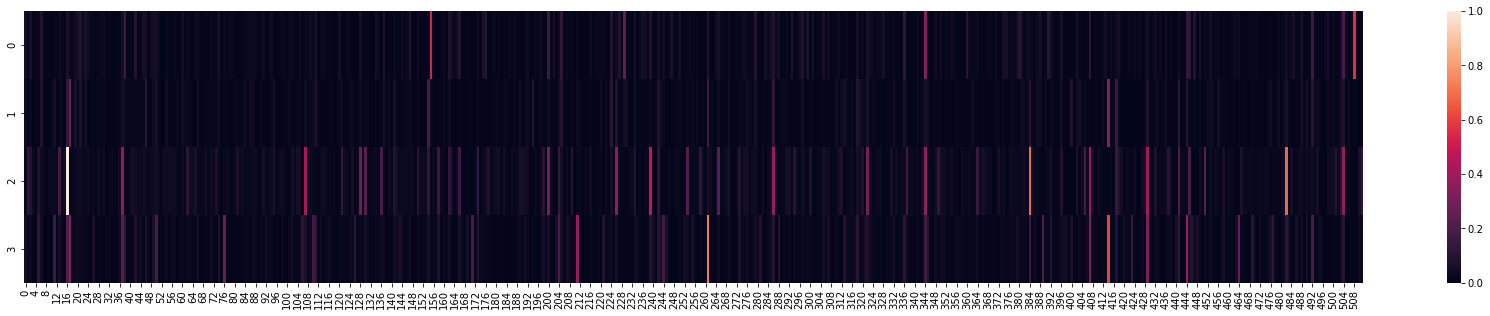

In [7]:
hm = grads - np.min(grads)
hm = hm / np.max(hm)
print(hm)

def view_grads(grads, fig_w, fig_h, fig_path='./heatmap.png'):
    f, ax = plt.subplots(figsize=(fig_w, fig_h), ncols=1)
    ax.set_xlabel('convolutional kernel')
    ax.set_ylabel('category')
    sns.heatmap(grads, annot=False, ax=ax)
    plt.savefig(fig_path, bbox_inches='tight')
    plt.show()
    #plt.clf()
    
view_grads(hm, 30, 5)

In [8]:
np.save('/nfs3-p2/zsxm/temp_path/conv1.npy', masks)

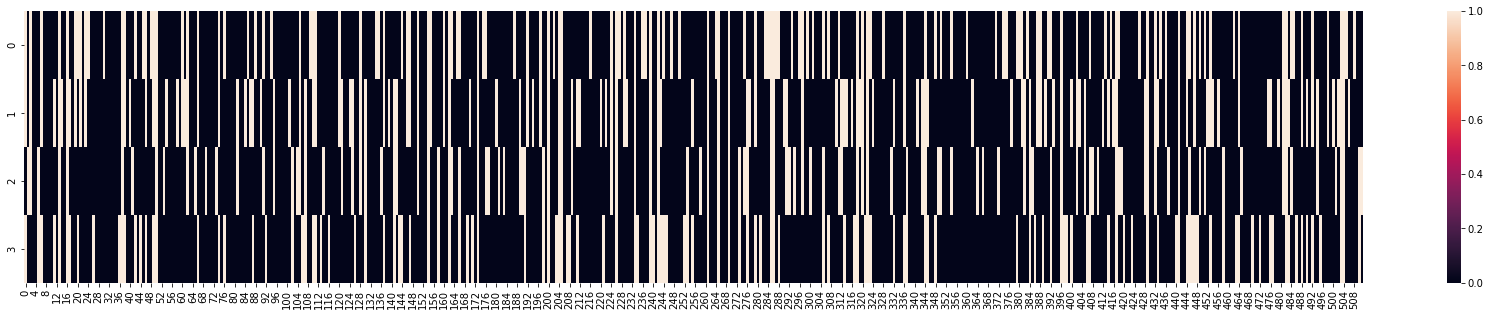

In [9]:
view_grads(masks, 30, 5)

In [43]:
class AdNoise:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
        outputs += torch.randn(outputs.shape).to(outputs.device)
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        return grads[0]
    
    def remove(self):
        self.handle.remove()
        
class Mul2:
    def __init__(self, model, module):
        self.model = model
        self.handle = module.register_forward_hook(self._get_output)
        
    def _get_output(self, module, inputs, outputs):
        self.outputs = outputs
        outputs *= 2
    
    def grads(self, outputs, retain_graph=True, create_graph=True):
        grads = torch.autograd.grad(outputs=outputs, inputs=self.outputs, retain_graph=retain_graph, create_graph=create_graph)
        self.model.zero_grad()
        return grads[0]
    
    def remove(self):
        self.handle.remove()

In [81]:
class Test(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.conv2 = nn.Conv2d(10, 1, 3)
        nn.init.constant_(self.conv1.weight, 1)
        nn.init.constant_(self.conv1.weight, 0)
        
    def forward(self, x):
        x = self.conv1(x)
        x = torch.exp(x)
        x = self.conv2(x)
        return x
    
test = Test()

In [84]:
h2 = Mul2(test, test.conv1)

In [82]:
h2.remove()

In [87]:
hn = AdNoise(test, test.conv1)

In [83]:
hn.remove()

In [88]:
a = torch.ones(2,3,6,6)
res = test(a)
ressum = res.sum()
print(res)
print(ressum)

tensor([[[[ 2.13770, -0.59085],
          [ 0.12120,  2.11927]]],


        [[[ 2.12890,  2.68057],
          [ 1.31703,  0.41613]]]], grad_fn=<MkldnnConvolutionBackward0>)
tensor(10.32995, grad_fn=<SumBackward0>)


In [86]:
print(h2.outputs)
print(h2.grads(ressum))

tensor([[[[ 0.03615,  0.03615,  0.03615,  0.03615],
          [ 0.03615,  0.03615,  0.03615,  0.03615],
          [ 0.03615,  0.03615,  0.03615,  0.03615],
          [ 0.03615,  0.03615,  0.03615,  0.03615]],

         [[ 0.00377,  0.00377,  0.00377,  0.00377],
          [ 0.00377,  0.00377,  0.00377,  0.00377],
          [ 0.00377,  0.00377,  0.00377,  0.00377],
          [ 0.00377,  0.00377,  0.00377,  0.00377]],

         [[ 0.25597,  0.25597,  0.25597,  0.25597],
          [ 0.25597,  0.25597,  0.25597,  0.25597],
          [ 0.25597,  0.25597,  0.25597,  0.25597],
          [ 0.25597,  0.25597,  0.25597,  0.25597]],

         [[-0.34284, -0.34284, -0.34284, -0.34284],
          [-0.34284, -0.34284, -0.34284, -0.34284],
          [-0.34284, -0.34284, -0.34284, -0.34284],
          [-0.34284, -0.34284, -0.34284, -0.34284]],

         [[-0.31575, -0.31575, -0.31575, -0.31575],
          [-0.31575, -0.31575, -0.31575, -0.31575],
          [-0.31575, -0.31575, -0.31575, -0.31575],
    

In [89]:
print(h2.outputs)
print(h2.grads(ressum))

tensor([[[[ 0.30127,  0.11240,  0.29888, -0.06942],
          [ 0.94889,  1.21283,  1.06022,  0.10926],
          [-0.98231, -0.14810,  1.17536,  0.78631],
          [-0.89676,  0.47519,  1.20985,  1.04300]],

         [[ 0.93710,  0.23161, -1.02955,  0.76933],
          [ 0.20654, -0.57718,  0.03613, -1.61051],
          [ 1.23581,  0.18494, -1.26181,  0.41256],
          [-0.38248,  0.75249,  0.28466, -1.50944]],

         [[ 0.51388,  1.76200, -0.32874,  0.64299],
          [ 1.65343, -0.88691, -0.11600,  0.29431],
          [ 0.05928,  1.43151, -1.04043,  2.81922],
          [ 1.07335,  3.00909,  2.03529,  0.40889]],

         [[-1.50593, -2.75498,  0.25422, -0.63300],
          [ 1.90071, -0.66370,  0.06909,  0.25347],
          [-1.36063,  0.24853, -0.94804, -0.09644],
          [-0.69281, -1.16150, -1.54912, -0.57281]],

         [[-0.45765,  0.28512, -0.20382, -0.69266],
          [-0.70992, -2.08257,  0.43022, -0.73136],
          [-0.40097, -1.28483, -0.43623, -1.90850],
    

In [90]:
print(hn.outputs)
print(hn.grads(ressum))

tensor([[[[ 0.30127,  0.11240,  0.29888, -0.06942],
          [ 0.94889,  1.21283,  1.06022,  0.10926],
          [-0.98231, -0.14810,  1.17536,  0.78631],
          [-0.89676,  0.47519,  1.20985,  1.04300]],

         [[ 0.93710,  0.23161, -1.02955,  0.76933],
          [ 0.20654, -0.57718,  0.03613, -1.61051],
          [ 1.23581,  0.18494, -1.26181,  0.41256],
          [-0.38248,  0.75249,  0.28466, -1.50944]],

         [[ 0.51388,  1.76200, -0.32874,  0.64299],
          [ 1.65343, -0.88691, -0.11600,  0.29431],
          [ 0.05928,  1.43151, -1.04043,  2.81922],
          [ 1.07335,  3.00909,  2.03529,  0.40889]],

         [[-1.50593, -2.75498,  0.25422, -0.63300],
          [ 1.90071, -0.66370,  0.06909,  0.25347],
          [-1.36063,  0.24853, -0.94804, -0.09644],
          [-0.69281, -1.16150, -1.54912, -0.57281]],

         [[-0.45765,  0.28512, -0.20382, -0.69266],
          [-0.70992, -2.08257,  0.43022, -0.73136],
          [-0.40097, -1.28483, -0.43623, -1.90850],
    

In [91]:
t = torch.ones(2,2)
print(id(t))

140329569117504


In [92]:
t += 1
print(id(t))

140329569117504


In [93]:
t = t+1
print(id(t))

140329569127696


In [100]:
a = 1
b = a
print(id(a), id(b))

93849141837280 93849141837280


In [101]:
def bad_append(new_item, a_list=[]):
 
    a_list.append(new_item)
 
    return a_list

In [106]:
print(bad_append(1))

[1, 1, 1, 1, 1]


In [107]:
a = (1,2)
a[0] = 3

TypeError: 'tuple' object does not support item assignment

In [109]:
class Test():
    a = None
    
def fun(x):
    x = Test()
    x.a = 7

In [113]:
t, k = Test(), Test()
t.a = 1
k.a = 2
p = t
print(p.a, t.a, k.a)
print(id(p), id(t), id(k))
p = k
print(p.a, t.a, k.a)
print(id(p), id(t), id(k))

1 1 2
140329570185904 140329570185904 140329570185712
2 1 2
140329570185712 140329570185904 140329570185712
